In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("GPU Available:", tf.test.is_gpu_available())


import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
from wfdb import processing
from scipy.fftpack import fft, ifft 
import pywt as pw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import Preprocessing
import FeatureExtraction
from importlib import reload
import transformers
import random
from transformers import Transformers
import scipy.signal as signal
from skimage.restoration import denoise_wavelet
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, ReLU

2023-09-05 14:05:04.555424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-09-05 14:05:11.111219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 14:05:12.537734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 14:05:12.538373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

GPU Available: True


loading the signals

In [3]:
reload(Preprocessing)

load = Preprocessing.preprocess()
X = load.loadSignal()


""" a 3D array of shape (19601, 12, 1000) where the first dimension represents the number of ECG signals,
 the second dimension represents the number of leads, and the third dimension represents the length of each signal. """


 
origin_signals = np.zeros((21799, 12, 1000))
# origin_test_signals = np.zeros((2198, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        
        origin_signals[sig, lead, :] = X[sig].T[lead][:] 

# for sig in range(x_test.shape[0]):
#     for lead in range(x_test.shape[2]):
        
#         origin_test_signals[sig, lead, :] = x_test[sig].T[lead][:] 



""" highpassedfiltered are just baseline removed """
# loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')


""" 'bandpass_filtered.npy' contains signals that have been thourogh 
baseline removal + moving avg + bandpass filter [0.5 - 25] """ 

# loaded_bandpassedfiltered_signal = np.load('bandpass_filtered_25.npy')

" 'bandpass_filtered.npy' contains signals that have been thourogh \nbaseline removal + moving avg + bandpass filter [0.5 - 25] "

In [9]:
reload(Preprocessing)

load = Preprocessing.preprocess()
Y = load.loadStatement()
Y = Y.reset_index()

In [3]:
Y['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21799, dtype: object

Freq Analysis

In [3]:
loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
# loaded_waveletfiltered_signals = loaded_waveletfiltered_signals.astype('float32')

In [5]:
loaded_waveletfiltered_signals.shape

(21799, 12, 1000)

In [4]:
filter = Preprocessing.preprocess()
sample_highpass_filtered = filter.highpassfilter(origin_signals[0][0], 100, 4, 0.5)
sample_bandpass_filtered = filter.bandpassfilter(origin_signals[0][0], 100, 4, 0.1, 35)
sample_movingavg_filtered = filter.movingaveragefilter(origin_signals[0][0])

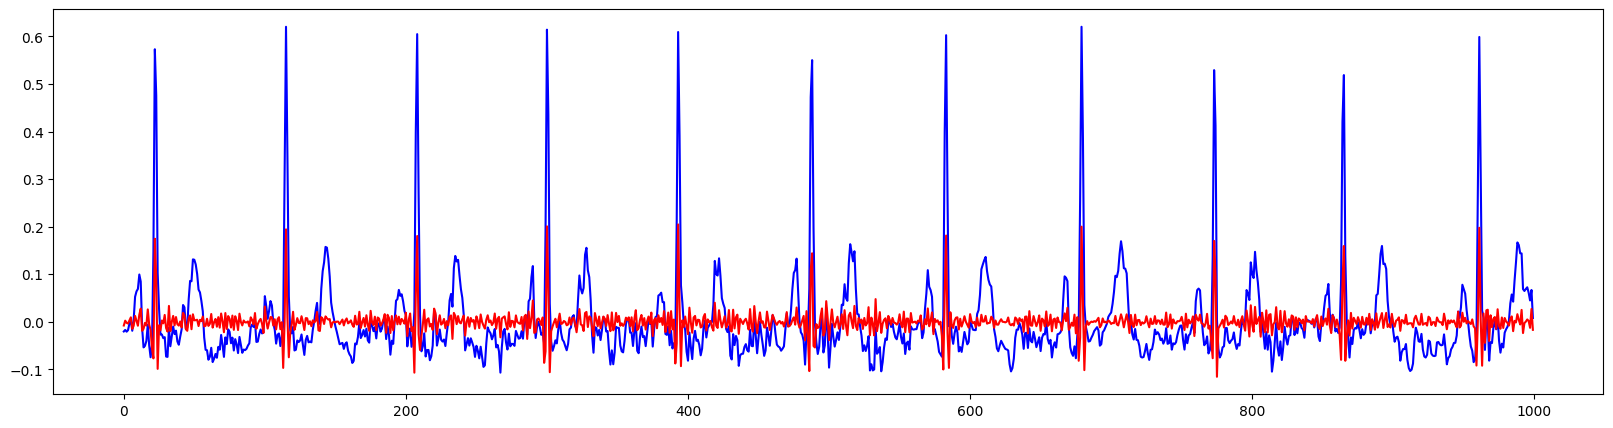

In [5]:
reload(Preprocessing)
show = Preprocessing.preprocess()

show.noise_representation(origin_signals[0][0], loaded_waveletfiltered_signals[0][0])
show.noise_representation(origin_signals[0][0], sample_highpass_filtered)
show.noise_representation(origin_signals[0][0], sample_bandpass_filtered)
show.noise_representation(origin_signals[0][0], sample_movingavg_filtered)

In [ ]:
reload(transformers)
T = Transformers()
T.FFT(loaded_waveletfiltered_signals[0][0][:])

Noise-removal

In [5]:
reload(Preprocessing)

""" all the filtering techniques are applied to the train signals """
filter = Preprocessing.preprocess()

baseline_removed_signals, bandpassfiltered_signals, smoothedfiltered_signals = np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000))


for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):
        

        """ baseline removal """
        baseline_removed_signals[sig][lead] = filter.highpassfilter(origin_signals[sig][lead][:], 100, 4, 0.5)



In [ ]:
""" smoothing using wavelets
this changes have been applied to the baseline filtered signals """

reload(Preprocessing)
filter = Preprocessing.preprocess()
waveletfiltered_signals = np.zeros((21799, 12, 1000))
loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        waveletfiltered_signals[sig][lead] = filter.wavelet_denoising(loaded_highpassedfiltered_signal[sig][lead][:])
        

In [ ]:
for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        smoothedfiltered_signals[sig][lead] = filter.movingaveragefilter(origin_signals[sig][lead][:])

np.save('movingavg_filtered.npy', bandpassfiltered_signals)
    


In [ ]:

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        """ smoothing the variations """
        bandpassfiltered_signals[sig][lead] = filter.bandpassfilter(baseline_removed_signals[sig][lead][:], 100, 4, 0.5, 35)

# np.save('bandpass_filtered.npy', bandpassfiltered_signals)


Extracting Features

In [5]:
"""  
locating the R Peaks for the entire dataset
- R_peaks should have a shape of (19601, 12), representing the R peak locations for each signal and lead.
- RR_intervals should have a shape of (19601, 12), representing the RR intervals for each signal and lead. 

"""


reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

# loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
R_peaks = []
RR_intervals = []


for signal in range(loaded_waveletfiltered_signals.shape[0]):
    # # signal_r_peaks = []
    # # for lead in signal:
    r_peaks, rr_intervals = extractor.R_peak_detection(loaded_waveletfiltered_signals[signal][1][:])
    r_peaks = np.array(r_peaks)
    # rr_intervals = np.diff(r_peaks)
    rr_intervals = np.array(rr_intervals)
    # # signal_r_peaks.append(r_peaks)
    R_peaks.append(r_peaks)
    RR_intervals.append(rr_intervals)



In [6]:
""" 
HRV measurements are calculated from the RR intervals of an ECG signal, 
which represent the time between successive R peaks in the QRS complex.

the HR and HRV are unique for an individual, 
but the measurements obtained from different leads may show slight variations 
due to the specific placement and orientation of the electrodes used to capture the signals.
since the differences of these measuremnets among leads are neglectable,
only the lead II which is the most commonly used lead, is used for the calculations.

"""

""" 
the lead commonly used for HRV analysis is Lead II.
 """

"""        hrv_features = [
            mean_rr,
            std_rr,
            rmssd, 
            nn50, 
            pnn50, 
            total_power, 
            vlf, 
            lf, 
            hf, 
            lf_norm,
            hf_norm, 
            lf_hf_ratio, 
            total_power_log, 
        ]
        
        """
""" the shape is 21799 * 12 """

reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()
HRV_features = []

for signal in range(loaded_waveletfiltered_signals.shape[0]):
    
    HRV_features.append(extractor.calculate_hrv_features(RR_intervals[signal]))

HRV_features_DF = pd.DataFrame(HRV_features, columns= ["mean_rr",
            "std_rr",
            "rmssd", 
            "nn50", 
            "pnn50", 
            "total_power", 
            "vlf", 
            "lf", 
            "hf", 
            "lf_norm",
            "hf_norm", 
            "lf_hf_ratio", 
            # "total_power_log"
            ])

HRV_features_DF



/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 5, using nperseg = 5
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 9, using nperseg = 9
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 11, using nperseg = 11
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarnin

,mean_rr,std_rr,rmssd,nn50,pnn50,total_power,vlf,lf,hf,lf_norm,hf_norm,lf_hf_ratio
0,0.939000,0.018138,0.024944,0,0.0,0.000870,0.0,0.000000,0.000870,0.000000,1.000000,0.000000
1,1.292000,0.061123,0.064031,0,0.0,0.006753,0.0,0.000000,0.006753,0.000000,1.000000,0.000000
2,0.944444,0.022662,0.020616,0,0.0,0.000921,0.0,0.000000,0.000921,0.000000,1.000000,0.000000
3,0.806364,0.035745,0.037417,0,0.0,0.003274,0.0,0.000000,0.003274,0.000000,1.000000,0.000000
4,0.912222,0.046375,0.057446,0,0.0,0.008931,0.0,0.000000,0.008931,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
21794,0.556875,0.049840,0.090000,0,0.0,0.027749,0.0,0.001869,0.025880,0.067363,0.932637,0.072229
21795,0.894444,0.010657,0.012748,0,0.0,0.000387,0.0,0.000000,0.000387,0.000000,1.000000,0.000000
21796,1.021429,0.044858,0.061101,0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN
21797,0.859000,0.103677,0.173526,0,0.0,0.088635,0.0,0.000000,0.088635,0.000000,1.000000,0.000000


In [27]:
""" 'age', 'sex', 'infarction_stadium1', 'infarction_stadium2', 'heart_axis ' are the used statements of data
 """


features = pd.DataFrame(index=Y.index)

features['sex'] = Y['sex']
features['age'] = Y['age']



features['infarction_stadium1'] = Y['infarction_stadium1'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

features['infarction_stadium2'] = Y['infarction_stadium2'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)


features['heart_axis'] = Y.heart_axis.replace({
    'LAD': 1,
    'ALAD': 2,
    'RAD': 3,
    'AXR': 4,
    'MID': 5,
    'ARAD': 6,
    'AXL': 7,
    'SAG': 8
}).fillna(0)


features['age'] = Y.age.replace({
    300: 30
})





""" adding hrv featres to the existing dataframe of features """

features= features.reset_index()
features = pd.concat([features, HRV_features_DF], axis=1)
features = features.drop(columns= "ecg_id")
features




,sex,age,infarction_stadium1,infarction_stadium2,heart_axis,mean_rr,std_rr,rmssd,nn50,pnn50,total_power,vlf,lf,hf,lf_norm,hf_norm,lf_hf_ratio
0,1,56.0,0.0,0.0,0.0,0.939000,0.018138,0.024944,0,0.0,0.000870,0.0,0.000000,0.000870,0.000000,1.000000,0.000000
1,0,19.0,0.0,0.0,0.0,1.292000,0.061123,0.064031,0,0.0,0.006753,0.0,0.000000,0.006753,0.000000,1.000000,0.000000
2,1,37.0,0.0,0.0,0.0,0.944444,0.022662,0.020616,0,0.0,0.000921,0.0,0.000000,0.000921,0.000000,1.000000,0.000000
3,0,24.0,0.0,0.0,0.0,0.806364,0.035745,0.037417,0,0.0,0.003274,0.0,0.000000,0.003274,0.000000,1.000000,0.000000
4,1,19.0,0.0,0.0,0.0,0.912222,0.046375,0.057446,0,0.0,0.008931,0.0,0.000000,0.008931,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,1,67.0,0.0,0.0,1.0,0.556875,0.049840,0.090000,0,0.0,0.027749,0.0,0.001869,0.025880,0.067363,0.932637,0.072229
21795,0,30.0,4.0,0.0,5.0,0.894444,0.010657,0.012748,0,0.0,0.000387,0.0,0.000000,0.000387,0.000000,1.000000,0.000000
21796,1,59.0,0.0,0.0,5.0,1.021429,0.044858,0.061101,0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN
21797,1,64.0,0.0,0.0,1.0,0.859000,0.103677,0.173526,0,0.0,0.088635,0.0,0.000000,0.088635,0.000000,1.000000,0.000000


In [ ]:
""" issue: when the total power of the heart rate variability spectrum is extremely low or close to zero
is causes the total_power_log to have an infinite value, so i cant scale them.
so i need to handel this and replace these infinite values with another number, like a large value out of my data range (99999) """

In [223]:
r_peaks_df_tf =r_peaks_df.transpose()
r_peaks_df_tf

,0,1,2,3,4,5,6,7,8,9,10
0,22,115,208,300,393,487,583,679,773,864,961


In [111]:
peak_columns = [f"Peak_{i+1}" for i in range(11)]
r_peaks_df_tf.columns = peak_columns
r_peaks_df_tf

,Peak_1,Peak_2,Peak_3,Peak_4,Peak_5,Peak_6,Peak_7,Peak_8,Peak_9,Peak_10,Peak_11
0,22,115,208,300,393,487,583,679,773,864,961


In [28]:
joblib.dump(features, 'features.joblib')

['features.joblib']

In [4]:
features = joblib.load('features.joblib')

In [10]:
""" defining the target labels """

labels = pd.DataFrame(0, index = Y.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')

for i in labels.index:
    for j in Y.loc[i, 'diagnostic_superclass']:
        labels.loc[i, j] = 1


# labels = labels.reset_index()
# labels.drop(columns= "ecg_id")
labels



,NORM,MI,STTC,CD,HYP
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
21794,0,0,1,0,0
21795,1,0,0,0,0
21796,0,0,1,0,0
21797,1,0,0,0,0


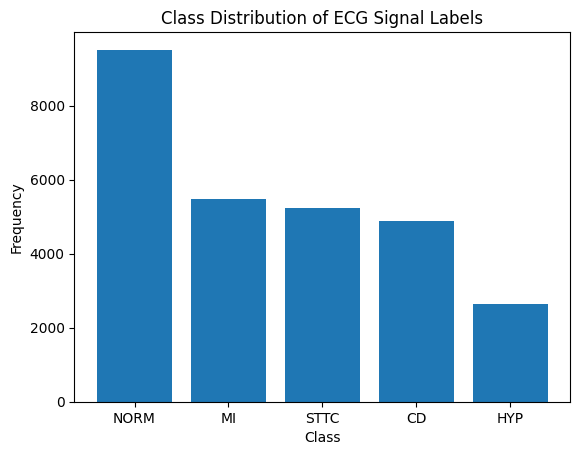

In [34]:
# Sum the rows to get the total count of each label
label_counts = labels.sum(axis=0)

# Get the labels from the column names of the DataFrame
class_labels = labels.columns

# Create a bar chart to show the class distribution
plt.bar(class_labels, label_counts)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution of ECG Signal Labels')
plt.show()

In [4]:
""" each lead represents a separate one-dimensional sequence of data points over time """

""" a 1D CNN can learn to extract meaningful features from each lead individually
    and combine them for classification or analysis. """





In [ ]:
""" an issue with the indexes of your dataframes and arrays not matching,
 it's important to ensure that the order of data in both the dataframe and signals array is aligned """

In [11]:
# Training data
X_train = features[Y.strat_fold <= 8]
Y_train = loaded_waveletfiltered_signals[np.where(Y.strat_fold <= 8)]
Z_train = labels[Y.strat_fold <= 8]

# Cross Valuation Data
X_val = features[Y.strat_fold == 9]
Y_val = loaded_waveletfiltered_signals[np.where(Y.strat_fold == 9)]
Z_val = labels[Y.strat_fold == 9]

# Test data
X_test = features[Y.strat_fold == 10]
Y_test = loaded_waveletfiltered_signals[np.where(Y.strat_fold == 10)]
Z_test = labels[Y.strat_fold == 10]


# ensure shapes match
print(f'X_train: {X_train.shape} Y_train: {Y_train.shape} Z_train: {Z_train.shape}')
print(f'X_val: {X_val.shape} Y_val: {Y_val.shape} Z_val: {Z_val.shape}')
print(f'X_test: {X_test.shape} Y_test: {Y_test.shape} Z_test: {Z_test.shape}')

X_train: (17418, 17) Y_train: (17418, 12, 1000) Z_train: (17418, 5)
X_val: (2183, 17) Y_val: (2183, 12, 1000) Z_val: (2183, 5)
X_test: (2198, 17) Y_test: (2198, 12, 1000) Z_test: (2198, 5)


In [41]:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [42]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_val_scaled = Y_scaler.transform(Y_val.reshape(-1, Y_val.shape[-1])).reshape(Y_val.shape)
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

Model

In [43]:
# X model
X_input = tf.keras.layers.Input(X_train_scaled.shape[1:], name="X_input")
X = Dense(128, activation='relu', name="X_dense_1")(X_input)
X = Dropout(0.4, name="X_dropout_1")(X)
X = Dense(128, activation='relu', name="X_dense_2")(X)
X = Dropout(0.4, name="X_dropout_2")(X)
X = Dense(64, activation='relu', name="X_dense_3")(X)
X = Dropout(0.4, name="X_dropout_3")(X)
X = Dense(32, activation='relu', name="X_dense_4")(X)
outputX = Dense(Z_train.shape[-1], activation='sigmoid', name="X_dense_5")(X)

modelX = tf.keras.Model(inputs=X_input, outputs=outputX)

In [44]:
gpus = tf.config.experimental.list_physical_devices('GPU')


In [45]:
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

Virtual devices cannot be modified after being initialized


In [46]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

    
modelX.compile(
    loss = 'binary_crossentropy',
    optimizer = keras.optimizers.legacy.Adam(),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

modelX.fit(
    X_train_scaled, Z_train, epochs = 40, batch_size=32, validation_data=(X_val_scaled, Z_val)
)

Epoch 1/40
545/545 [==============================] - 9s 7ms/step - loss: nan - binary_accuracy: 0.6207 - precision: 0.3140 - recall: 6.8173e-04 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
545/545 [==============================] - 3s 6ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
545/545 [==============================] - 3s 6ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
545/545 [==============================] - 3s 6ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
5

KeyboardInterrupt: 

In [262]:
score = modelX.evaluate(X_val, Z_val, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: nan
Test accuracy: 0.620629072189331


In [18]:
# Y model

Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:], name="Y_input")

Y = Conv1D(32, 3, padding='same', name="Y_conv_1")(Y_input)
Y = BatchNormalization(name="Y_norm_1")(Y)
Y = ReLU(name="Y_relu_1")(Y)
Y = MaxPooling1D(2, name="Y_max_1")(Y)

Y = Conv1D(64, 3, padding='same', name="Y_conv_2")(Y)
Y = BatchNormalization(name="Y_norm_2")(Y)
Y = ReLU(name="Y_relu_2")(Y)
Y = MaxPooling1D(2, name="Y_max_2")(Y)

Y = Conv1D(128, 3, padding='same', name="Y_conv_3")(Y)
Y = BatchNormalization(name="Y_norm_3")(Y)
Y = ReLU(name="Y_relu_3")(Y)

Y = GlobalAveragePooling1D(name="Y_global")(Y)

outputY = Dropout(0.4, name="Y_dropout")(Y)

In [263]:
outputY.shape

TensorShape([None, 128])

In [19]:
Z = Concatenate(name="Z_concat")([outputX, outputY])
Z = Dense(64, activation='relu', name="Z_dense_1")(Z)
Z = Dropout(0.4, name="Z_dropout_1")(Z)
Z = Dense(64, activation='relu', name="Z_dense_2")(Z)
Z = Dropout(0.4, name="Z_dropout_2")(Z)
output = Dense(Z_train.shape[-1], activation="sigmoid", name="Z_dense_3")(Z)

modelZ = tf.keras.Model(inputs=[X_input, Y_input], outputs=output)

In [20]:
modelZ.compile(
    loss='binary_crossentropy',
    optimizer= keras.optimizers.legacy.Adam(),
    metrics=['binary_accuracy', 'Precision', 'Recall']
)


modelZ.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Y_input (InputLayer)        [(None, 12, 1000)]           0         []                            
                                                                                                  
 Y_conv_1 (Conv1D)           (None, 12, 32)               96032     ['Y_input[0][0]']             
                                                                                                  
 Y_norm_1 (BatchNormalizati  (None, 12, 32)               128       ['Y_conv_1[0][0]']            
 on)                                                                                              
                                                                                                  
 Y_relu_1 (ReLU)             (None, 12, 32)               0         ['Y_norm_1[0][0]']      

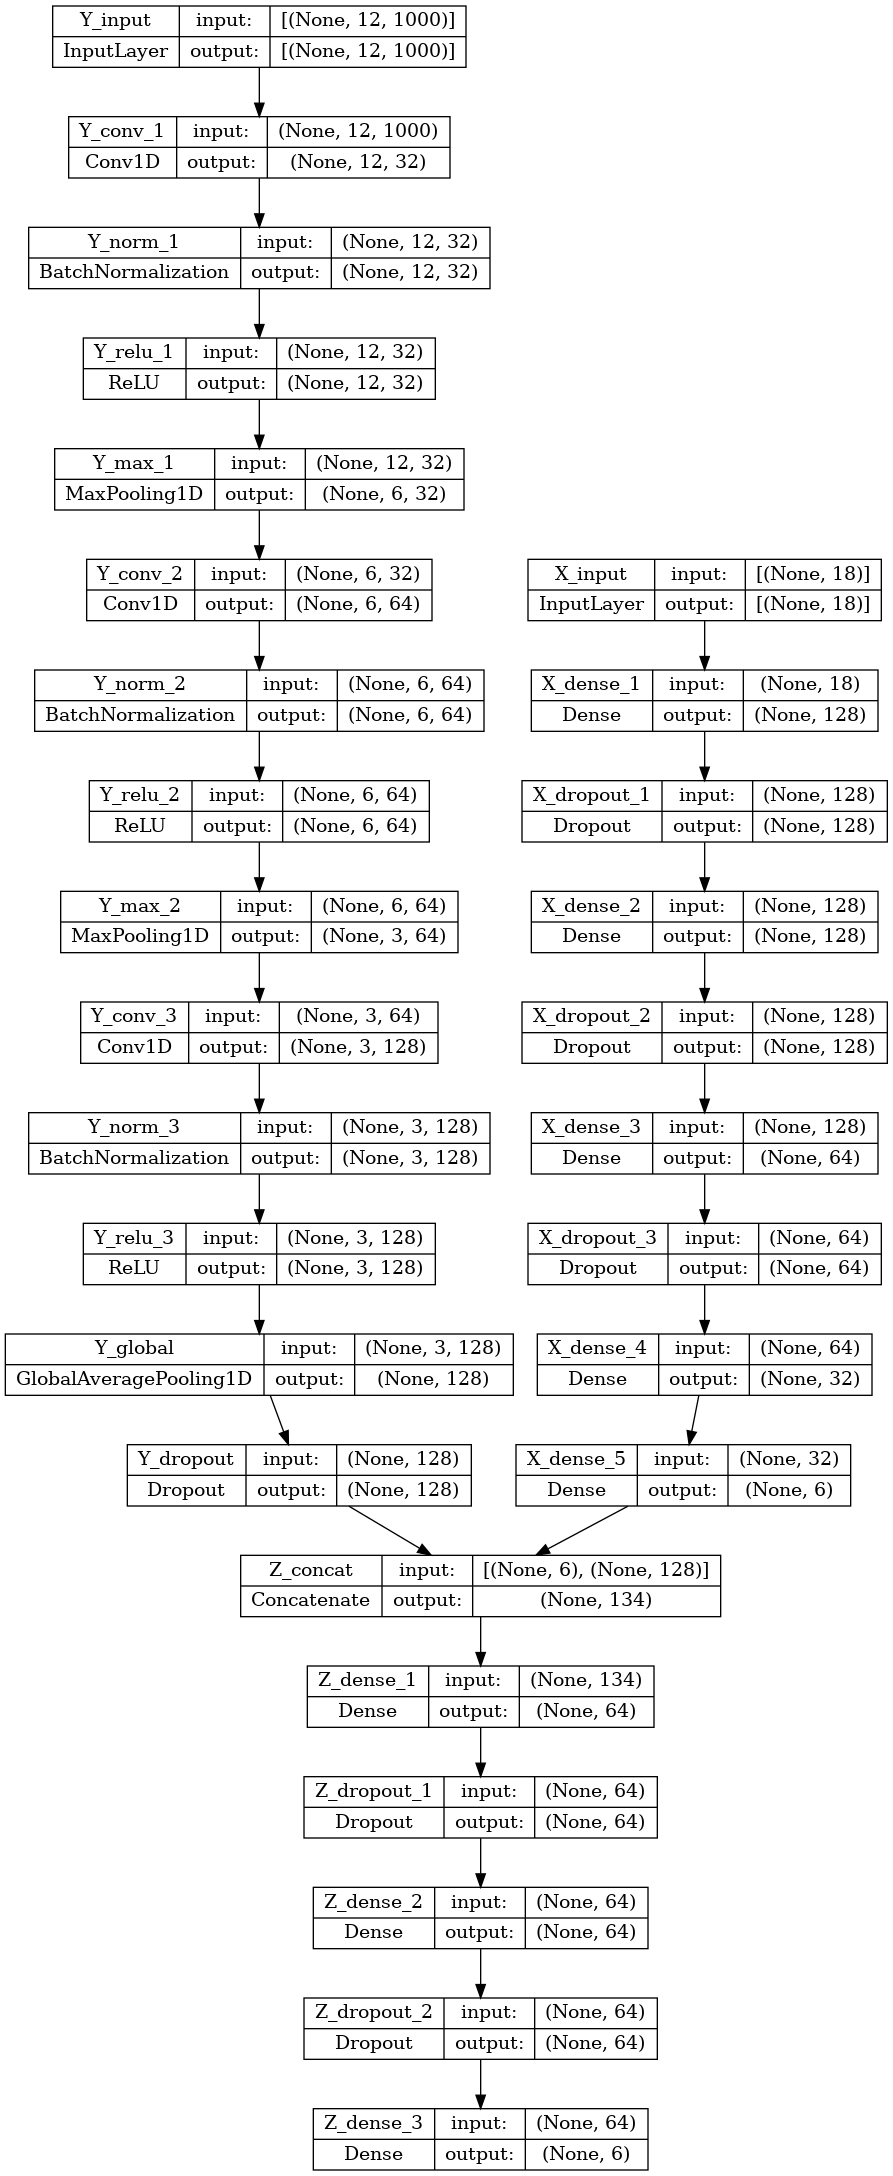

In [266]:
from keras.utils import plot_model

tf.keras.utils.plot_model(modelZ, show_shapes=True)
plot_model(modelZ, show_shapes=True, show_layer_names=True)

In [21]:

fitting = modelZ.fit(
    [X_train_scaled, Y_train_scaled], Z_train, epochs=50, batch_size=32, validation_data=([X_val_scaled, Y_val_scaled], Z_val)
)

2023-08-30 16:18:44.922453: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 836064000 exceeds 10% of free system memory.
2023-08-30 16:18:46.039216: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 836064000 exceeds 10% of free system memory.


Epoch 1/50


2023-08-30 16:18:50.163355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-30 16:19:00.049208: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-30 16:19:00.050077: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-30 16:19:00.050130: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-30 16:19:00.050880: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-30 16:19:00.050989: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

545/545 [==============================] - 24s 14ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
545/545 [==============================] - 7s 12ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
545/545 [==============================] - 7s 12ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
545/545 [==============================] - 7s 12ms/step - loss: nan - binary_accuracy: 0.6210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.6206 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
545

In [38]:
modelX.evaluate(X_test_scaled, Z_test)

69/69 [==============================] - 0s 6ms/step - loss: nan - binary_accuracy: 0.7460 - precision: 0.0000e+00 - recall: 0.0000e+00


[nan, 0.7459507584571838, 0.0, 0.0]

In [22]:
features

,ecg_id,sex,age,infarction_stadium1,infarction_stadium2,heart_axis,mean_rr,std_rr,rmssd,nn50,pnn50,total_power,vlf,lf,hf,lf_norm,hf_norm,lf_hf_ratio
0,1,1,56.0,0.0,0.0,0.0,0.939000,0.018138,0.024944,0,0.0,0.000870,0.0,0.000000,0.000870,0.000000,1.000000,0.000000
1,2,0,19.0,0.0,0.0,0.0,1.292000,0.061123,0.064031,0,0.0,0.006753,0.0,0.000000,0.006753,0.000000,1.000000,0.000000
2,3,1,37.0,0.0,0.0,0.0,0.944444,0.022662,0.020616,0,0.0,0.000921,0.0,0.000000,0.000921,0.000000,1.000000,0.000000
3,4,0,24.0,0.0,0.0,0.0,0.806364,0.035745,0.037417,0,0.0,0.003274,0.0,0.000000,0.003274,0.000000,1.000000,0.000000
4,5,1,19.0,0.0,0.0,0.0,0.912222,0.046375,0.057446,0,0.0,0.008931,0.0,0.000000,0.008931,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,1,67.0,0.0,0.0,1.0,0.556875,0.049840,0.090000,0,0.0,0.027749,0.0,0.001869,0.025880,0.067363,0.932637,0.072229
21795,21834,0,30.0,4.0,0.0,5.0,0.894444,0.010657,0.012748,0,0.0,0.000387,0.0,0.000000,0.000387,0.000000,1.000000,0.000000
21796,21835,1,59.0,0.0,0.0,5.0,1.021429,0.044858,0.061101,0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN
21797,21836,1,64.0,0.0,0.0,1.0,0.859000,0.103677,0.173526,0,0.0,0.088635,0.0,0.000000,0.088635,0.000000,1.000000,0.000000
